In [1]:
import random; random.seed(42)
import numpy as np; np.random.seed(42)
import torch; torch.manual_seed(42)

from ConceptMining import ConceptMiner

[nltk_data] Downloading package stopwords to /app/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:

batch_size = 70
images = [i for i in glob("../datatset/Images/*.jpg")]
encodings, captions = get_images_captions(images, get_encodings = True, batch_size = batch_size)


  0%|          | 0/116 [00:00<?, ?it/s]

 92%|█████████▏| 107/116 [15:40<01:19,  8.79s/it]


FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/jde/datatset/Images/492341908_1ef53be265.jpg'

In [5]:
captions

['little girl pink dress',
 'two dogs playing road',
 'child sitting grass',
 'woman laying bench',
 'man wearing hat']

In [ ]:

import pickle

with open("encodings.pkl", "rb") as f:
    encodings = pickle.load(f)
    captions = encodings['captions']
    encodings = encodings['encodings']
    
    from ConceptModeling import ConceptModel
    
from hdbscan import HDBSCAN
from umap import UMAP

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean',
                cluster_selection_method='eom', prediction_data=True)
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')


concept_model = ConceptModel(hdbscan_model=hdbscan_model, umap_model=umap_model, ctfidf= True)
concepts = concept_model.fit_transform(images = images, image_embeddings = encodings,
                                       docs = captions, #selected_nouns,
                                       n_topics_per_cluster = 30,
                                       text_image_matched = True,
                                       text_econder={'processor': processor, 'encoder': model.text_model, 'batch_size': batch_size})

In [32]:
concept_model.topics

{-1: 'blocks, police, playing, officer, room, wall, uniform, front, standing, mustache, house, boxes, girl, child, brick, chair, wooden, little, mop, neck, salon, woman, bunch, , server, hospital, factory, lab, table, white',
 0: 'smiling, tie, glasses, suit, standing, bench, city, store, beard, front, wearing, wall, blue, shirt, sitting, , , , , , , , , , , , , , , ',
 1: 'hat, blue, safety, vest, hard, shirt, working, piece, car, welding, field, machine, camera, factory, holding, workbench, taxi, site, truck, shovel, shop, using, warehouse, pot, wood, work, plants, yellow, metal, garden',
 2: 'food, kitchen, chef, two, holding, preparing, plates, coat, hamburgers, posing, picture, uniform, lab, white, hat, woman, , , , , , , , , , , , , , ',
 3: 'desk, sitting, computer, laptop, suit, table, tie, papers, front, glasses, men, office, headphones, red, shirt, server, , beard, looking, bookcase, book, wearing, lab, two, white, coat, blue, woman, standing, ',
 4: 'woman, stel, pink, lab, 

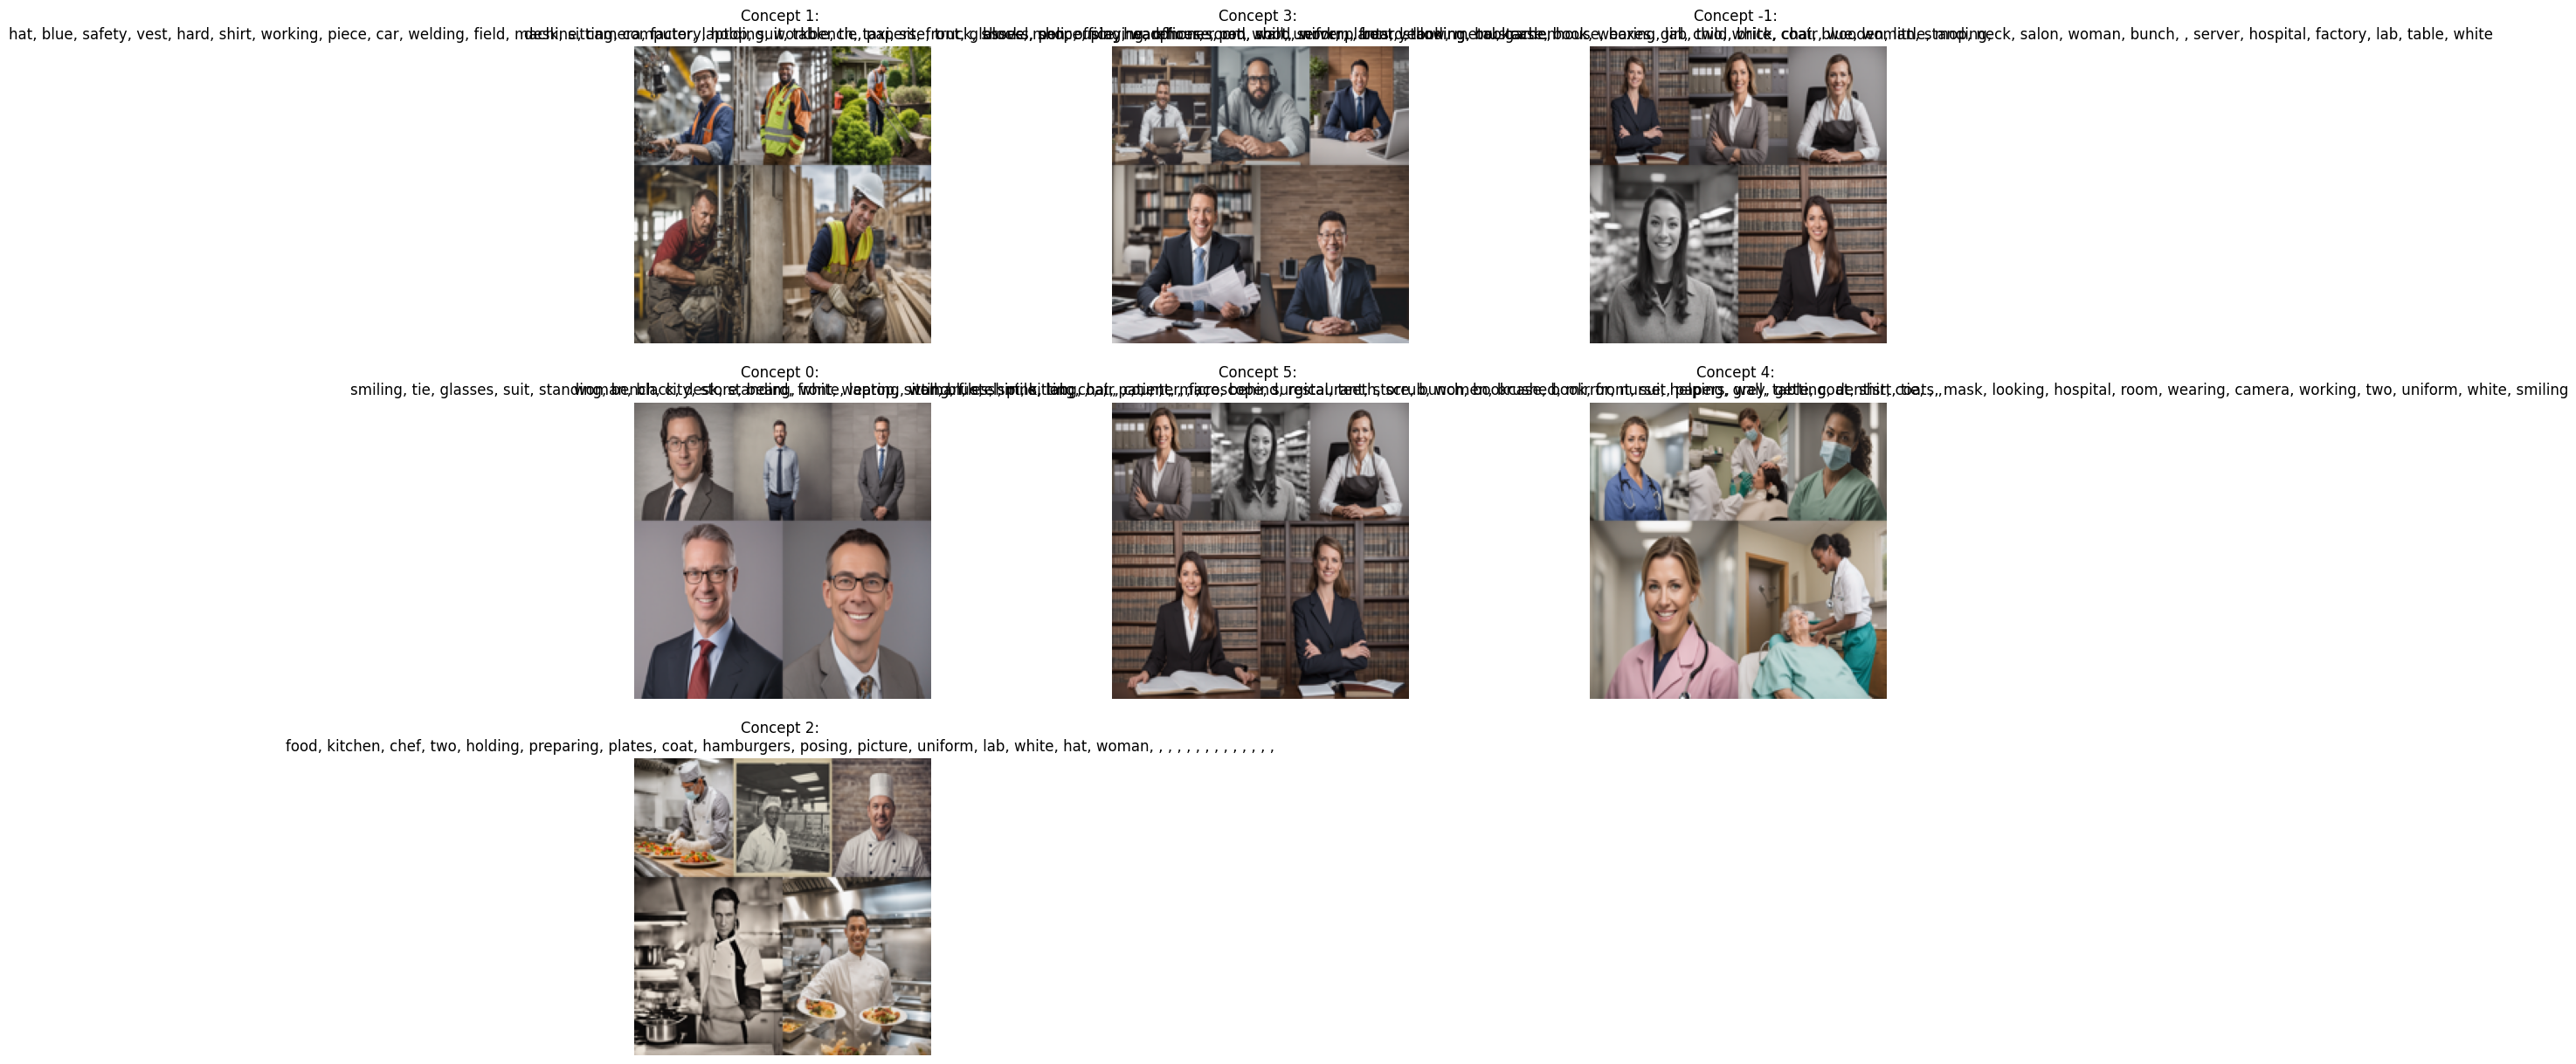

In [33]:
z = concept_model.visualize_concepts(top_n=1e6) 

In [34]:
generated_concepts = list(concept_model.topics.values())
with open("generated_concepts.pkl", "wb") as f:
    pickle.dump(generated_concepts, f)


In [35]:
import pandas as pd, pickle
ground_truth = list(set(pd.read_excel("Basic_concepts_superset.xlsx").fillna("-1")['Basic Concept'].values))
generated_concepts = pickle.load(open("generated_concepts.pkl", "rb"))
generated_concepts = list(set([k.strip() for i in generated_concepts for k in i.split(',')]) - {''})

In [36]:
len(ground_truth)

324

#### Expand Semantics

In [37]:

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

def extend_concepts(concepts):
    extended_concepts = []
    for concept in concepts:
        for ss in wn.synsets(concept):
            extended_concepts += ss.lemma_names()
    return list(set(extended_concepts))

extend_generated_concepts = extend_concepts(generated_concepts)
extend_ground_truth = extend_concepts(ground_truth)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/labadier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Match by counting

In [112]:

def get_matches(points, ground_truth):

    lemmatizer = WordNetLemmatizer()

    lematized_points = [lemmatizer.lemmatize(i) for i in points]
    lematized_ground_truth = [lemmatizer.lemmatize(i) for i in ground_truth]
    
    matches = sum([1 for i in lematized_points if i in lematized_ground_truth])

    return matches


matches = get_matches(generated_concepts, ground_truth)
matches_exended = get_matches(extend_generated_concepts, extend_ground_truth)

print(f"Matches: {matches} Original - Generated: {len(ground_truth) -  matches} Generated - Original: {len(generated_concepts) - matches} Proportion: {matches/len(ground_truth)}")
print(f"Matches: {matches_exended} Original - Generated: {len(extend_ground_truth) -  matches_exended} Generated - Original: {len(extend_generated_concepts) - matches_exended} Proportion: {matches_exended/len(extend_ground_truth)}")

Matches: 43 Original - Generated: 281 Generated - Original: 72 Proportion: 0.13271604938271606
Matches: 647 Original - Generated: 1203 Generated - Original: 702 Proportion: 0.3497297297297297


In [39]:
len(generated_concepts)

115

In [121]:
import traceback
matches = [matches_exended]

list_user_added = []

df = pd.read_excel("Basic_concepts_superset.xlsx", sheet_name="Mapping CM Nodes <> Concepts").fillna("-1")
for participant in  tqdm(set(df['﻿Participant ID'].values)):
    user_added = df[df['﻿Participant ID'] == participant]['Original concept'].values
    normalized = df[df['﻿Participant ID'] == participant]["Mapped Basic concept"].values
    user_added = [str(user_added[i]) if normalized[i] == "-1" else str( normalized[i]) for i in range(len(user_added)) if i != "-1"]
    user_added = list(set(user_added) - set(["-1"]))

    list_user_added += [user_added]
    try:
        user_added = extend_concepts(user_added)
    except:
        print(traceback.format_exc())
    matches += [get_matches(user_added, extend_ground_truth)]
    

100%|██████████| 20/20 [00:00<00:00, 69.39it/s]


### Ranking according to matching

In [122]:
sorted_values = sorted([(value, i) for i, value in enumerate(matches)], reverse = True)
sorted_values

[(682, 2),
 (647, 0),
 (456, 3),
 (444, 17),
 (440, 5),
 (375, 11),
 (320, 13),
 (300, 6),
 (293, 16),
 (259, 10),
 (208, 15),
 (186, 4),
 (177, 9),
 (173, 18),
 (151, 14),
 (128, 20),
 (93, 1),
 (86, 8),
 (85, 19),
 (45, 12),
 (42, 7)]

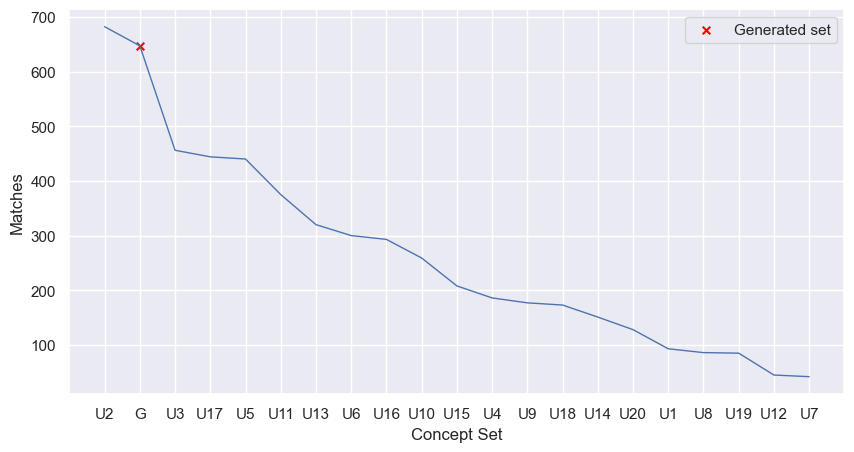

In [124]:
## from the sorted_values array of tuples plot a graph of the sorted values and highlight the value with index 0

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(10, 5))
plt.plot([i[0] for i in sorted_values], linewidth=.99)
plt.scatter( 1, 647, color='red', marker='x', s=30, label='Generated set')
plt.xlabel("Concept Set")
plt.xticks((range(len(sorted_values))), [f"U{i[1]}" if i[1] != 0 else "G" for i in sorted_values])

plt.ylabel("Matches")
plt.legend()
plt.show()




In [12]:
sorted([(value, len(user_added[i]), i) for i, value in enumerate(matches)], reverse = True)[5:]

[(375, 4, 11),
 (320, 4, 13),
 (300, 7, 6),
 (293, 5, 16),
 (259, 4, 10),
 (208, 7, 15),
 (186, 7, 4),
 (177, 8, 9),
 (173, 11, 18),
 (151, 6, 14),
 (128, 6, 20),
 (93, 7, 1),
 (86, 8, 8),
 (85, 7, 19),
 (45, 6, 12),
 (42, 8, 7)]

### Embeddgin base ranking

In [53]:
#compute embedding for every concept in both ground truth and generated concepts
#cluster those embeddings and compute the pairwise silohoette score between the ground truth and generated clusters
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from umap import UMAP

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")


In [54]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embedding(sentences, model, tokenizer, batch_size = 16):
    with torch.no_grad():

        output = None
        for i in range(0, len(sentences), batch_size):
            encoded_input = tokenizer(sentences[i: i + batch_size], padding=True, return_tensors='pt')

            model_output = model(**encoded_input)
            sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            output = sentence_embeddings if output is None else torch.cat([output, sentence_embeddings])

    return output

ground_truth_embeddings = get_embedding(ground_truth, model, tokenizer)
ground_truth_extended_embeddings = get_embedding(extend_ground_truth, model, tokenizer)


generated_concepts_embeddings = get_embedding(generated_concepts, model, tokenizer)
generated_concepts_extended_embeddings = get_embedding(extend_generated_concepts, model, tokenizer)

user_concept_embeddings = []

for list_added in list_user_added:
    user_concept_embeddings += [get_embedding(list_added, model, tokenizer)]

ground_truth_embeddings.shape, generated_concepts_embeddings.shape

(torch.Size([324, 384]), torch.Size([115, 384]))

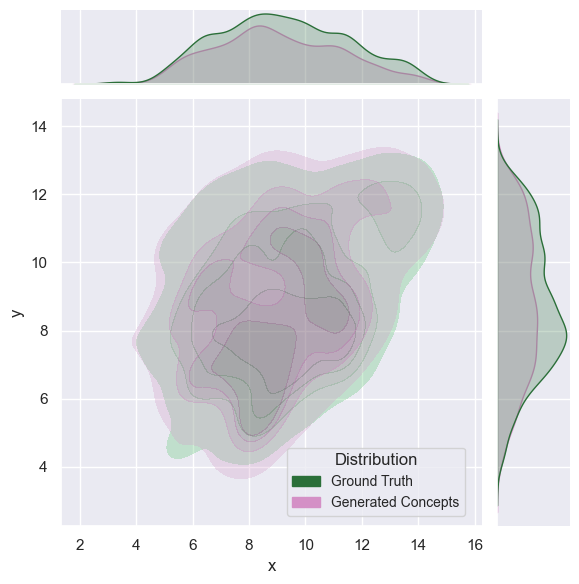

In [107]:
#tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


umap_model = UMAP( n_components=2, min_dist=0.0, metric='cosine')
# tsne_embeddings = tsne.fit_transform(torch.cat([ground_truth_embeddings, generated_concepts_embeddings]).detach().numpy())

# tsne_embeddings = umap_model.fit_transform(torch.cat([ground_truth_extended_embeddings, generated_concepts_extended_embeddings]).detach().numpy())
dataplot = pd.DataFrame({'x': tsne_embeddings[:, 0],
                        'y': tsne_embeddings[:, 1],
                         'Distribution': ['Ground Truth']*len(extend_ground_truth) +\
                              ['Generated Concepts']*len(generated_concepts_extended_embeddings)})

z = sns.jointplot(data=dataplot, x='x', y='y', hue='Distribution',
               kind='kde', 
               fill=True, 
               alpha=0.3, 
               palette="cubehelix",
               common_norm=False,
               levels=5,
               )
sns.move_legend(z.ax_joint, "upper left", bbox_to_anchor=(.52, .2), title='Distribution', 
               fontsize='small', 
               )
plt.show()
# sns.plot(x = tsne_embeddings[:len(extend_ground_truth), 0],
#              y = tsne_embeddings[:len(extend_ground_truth), 1], 
#              color='red', alpha=0.2, label='Ground Truth', 
#             #  s=20,
#              kind='hex')
# sns.plot(x = tsne_embeddings[len(extend_ground_truth):, 0], 
#             y = tsne_embeddings[len(extend_ground_truth):, 1],
#             color='#4CB391', alpha=0.7,
#             label='Generated Concepts',
#             kind='hex', 
#             # s=5
#             )

# plt.scatter(tsne_embeddings[:len(ground_truth_embeddings), 0], tsne_embeddings[:len(ground_truth_embeddings), 1], color='red', alpha=0.4, label='Ground Truth')
# plt.scatter(tsne_embeddings[len(ground_truth_embeddings):, 0], tsne_embeddings[len(ground_truth_embeddings):, 1], color='blue', alpha=0.7, label='Generated Concepts')
# plt.legend()
# plt.show()


In [56]:
#kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def get_space_clusterings(embeddings, n_clusters = 7):

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
    ground_truth_embeddings_projection = umap_model.fit_transform(embeddings)
    kmeans.fit(ground_truth_embeddings_projection)
    labels = kmeans.labels_
    
    del kmeans
    return labels, ground_truth_embeddings_projection

labels_ground_truth, ground_truth_embeddings_projection = get_space_clusterings(ground_truth_embeddings)
labels_generated, generated_concepts_embeddings_projection = get_space_clusterings(generated_concepts_embeddings)

usr_labels = []
usr_embeddings_projection = []
for user_concept_embedding in user_concept_embeddings:
    labels, embeddings_projection = get_space_clusterings(user_concept_embedding)
    usr_labels += [labels]
    usr_embeddings_projection += [embeddings_projection]

/Users/labadier/projects/.env/lib/python3.12/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/Users/labadier/projects/.env/lib/python3.12/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/Users/labadier/projects/.env/lib/python3.12/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


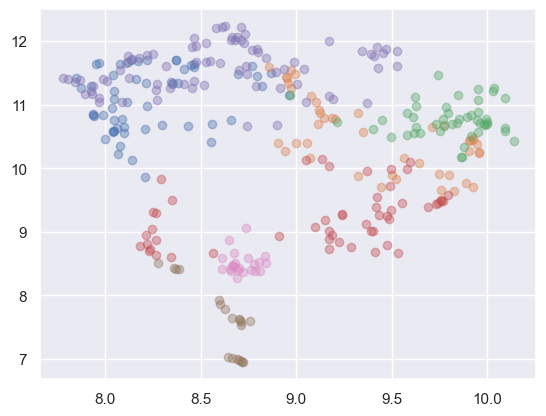

In [57]:
#tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine')
tsne_embeddings = umap_model.fit_transform(ground_truth_embeddings)

for i in range(7):
    plt.scatter(ground_truth_embeddings_projection[labels_ground_truth == i, 0], ground_truth_embeddings_projection[labels_ground_truth == i, 1], alpha=0.4)
plt.show()

In [58]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

matching = np.zeros((7, 7))

def get_cluster_matching(cluster1, cluster2, metric):
    if metric == 'centroid':
        cluster1_center = cluster1.mean( axis=0)
        cluster2_center = cluster2.mean( axis=0)

        return cosine_similarity(cluster1_center.reshape(1, -1), cluster2_center.reshape(1, -1))
    if metric == 'silhouette':
        return silhouette_score(np.concatenate([cluster1, cluster2]), [0]*len(cluster1) + [1]*len(cluster2))

for generated_cluster in range(7):
    generated_elements = generated_concepts_embeddings[labels_generated == generated_cluster]
    for ground_truth_cluster in range(7):
        ground_truth_elements = ground_truth_embeddings[labels_ground_truth == ground_truth_cluster]
        
        score = get_cluster_matching(ground_truth_elements, generated_elements, 'centroid')
        matching[ground_truth_cluster, generated_cluster] = score.item()

list_usr_matching = []
for user_labels, user_embeddings in zip(usr_labels, user_concept_embeddings):
    matching_usr = np.zeros((7, 7))
    user_embeddings = user_embeddings[user_labels == generated_cluster]
    for generated_cluster in range(len(set(user_labels))):
        for ground_truth_cluster in range(7):
            ground_truth_elements = ground_truth_embeddings[labels_ground_truth == ground_truth_cluster]
            score = get_cluster_matching(ground_truth_elements, user_embeddings, 'centroid')
            matching_usr[ground_truth_cluster, generated_cluster] = score.item()
    list_usr_matching += [matching_usr]

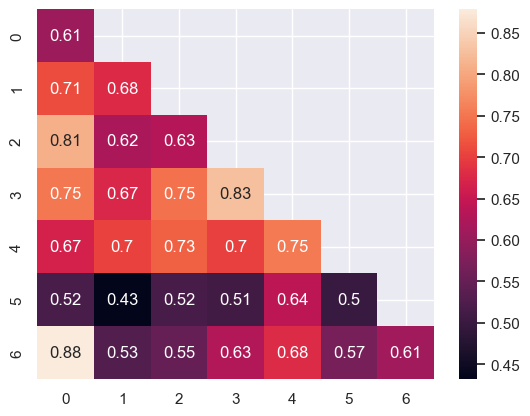

In [59]:
#plot the matching matrix lower triangle

import seaborn as sns
import matplotlib.pyplot as plt

mask = np.triu(np.ones_like(matching, dtype=bool)) - np.eye(7)
sns.heatmap(matching, annot=True, mask=mask)
plt.show()


In [60]:
# get the n elements closer to the centroid of the cluster

def get_closest_elements_to_centroid(embeddings, labels, concepts, n = 5):

    output = []
    for i in range(len(set(labels))):
        cluster_data_points = embeddings[labels == i]
        names_data_points = [concepts[j] for j in range(len(concepts)) if labels[j] == i]

        centroid = cluster_data_points.mean(0)
        distances = torch.norm(cluster_data_points - centroid, dim=1)
    
        k_nearer = distances.argsort()[:n]

        k_nearer = [names_data_points[i]  for i in k_nearer]
        output.append(k_nearer)
    return output

top_gt = get_closest_elements_to_centroid(ground_truth_embeddings, labels_ground_truth, ground_truth, n = 5)
top_generated = get_closest_elements_to_centroid(generated_concepts_embeddings, labels_generated, generated_concepts, n = 5)

In [61]:
print("Representative Ground Truth Concepts")
for i in range(7):
    print(f"Cluster {i}: {top_gt[i]}")

print("Representative Generated Concepts")
for i in range(7):
    print(f"Cluster {i}: {top_generated[i]}")
    

Representative Ground Truth Concepts
Cluster 0: ['office', 'desk work', 'industry', 'working', 'service']
Cluster 1: ['portrait', 'photo', 'wide', 'art', 'illustration']
Cluster 2: ['shirt', 'headwear', 'gloves', 'helmet', 'blouse']
Cluster 3: ['active', 'hair', 'friendly', 'male', 'adult']
Cluster 4: ['food', 'kitchen', 'car', 'products', 'garage']
Cluster 5: ['50-80', '18-30', '30-50', 'none', '80+']
Cluster 6: ['colored', 'black', 'white', 'gray', 'green']
Representative Generated Concepts
Cluster 0: ['black', 'white', 'grey', 'blue', 'red']
Cluster 1: ['chair', 'patient', 'nurse', 'surgical', 'hospital']
Cluster 2: ['working', 'work', 'using', 'playing', 'helping']
Cluster 3: ['beard', 'face', 'mustache', 'teeth', 'hair']
Cluster 4: ['piece', 'girl', 'picture', 'bunch', 'two']
Cluster 5: ['computer', 'machine', 'office', 'desk', 'factory']
Cluster 6: ['wood', 'kitchen', 'food', 'wooden', 'wall']


In [62]:
sorted_values = sorted([(value, (i, j)) for i in range(matching.shape[0]) for j, value in enumerate(matching[i])])

matched = [[0]*len(matching), [0]*len(matching[0])]
child = [0]*len(matching[0])

for value, (i, j) in reversed(sorted_values):
    if not matched[0][i] and not matched[1][j]:
        child[i] = j
        matched[0][i] = matched[1][j] = 1

In [63]:
child
print("Match Ground Truth Cluster --> Generated Cluster")
for i, j in enumerate(child):
    print(f"Ground Truth Cluster {top_gt[i]} --> Generated Cluster {top_generated[j]}")

Match Ground Truth Cluster --> Generated Cluster
Ground Truth Cluster ['office', 'desk work', 'industry', 'working', 'service'] --> Generated Cluster ['computer', 'machine', 'office', 'desk', 'factory']
Ground Truth Cluster ['portrait', 'photo', 'wide', 'art', 'illustration'] --> Generated Cluster ['chair', 'patient', 'nurse', 'surgical', 'hospital']
Ground Truth Cluster ['shirt', 'headwear', 'gloves', 'helmet', 'blouse'] --> Generated Cluster ['beard', 'face', 'mustache', 'teeth', 'hair']
Ground Truth Cluster ['active', 'hair', 'friendly', 'male', 'adult'] --> Generated Cluster ['piece', 'girl', 'picture', 'bunch', 'two']
Ground Truth Cluster ['food', 'kitchen', 'car', 'products', 'garage'] --> Generated Cluster ['wood', 'kitchen', 'food', 'wooden', 'wall']
Ground Truth Cluster ['50-80', '18-30', '30-50', 'none', '80+'] --> Generated Cluster ['working', 'work', 'using', 'playing', 'helping']
Ground Truth Cluster ['colored', 'black', 'white', 'gray', 'green'] --> Generated Cluster ['bl

In [64]:
import numpy as np
#import pca
from sklearn.decomposition import PCA
epsilon = 1e-10

# Project all the embeddings to a R^d space space. In this case, we will use d=12 because 
# the smaller user set of concepts is 11 and we want to ensure our covariance matrices to
# be invertible.

# umap_model = UMAP(n_neighbors=15, n_components=11, min_dist=0.0, metric='cosine')
pca = PCA(n_components=11, random_state=42)
# full_data = torch.cat([ground_truth_embeddings, generated_concepts_embeddings])
# for user_embeddings in user_concept_embeddings:
#     full_data = torch.cat([full_data, user_embeddings])


## train on top of ALL the embeddings
full_data = torch.cat([ground_truth_embeddings, user_concept_embeddings[0]])
for user_embeddings in user_concept_embeddings[1:]:
    full_data = torch.cat([full_data, user_embeddings])

pca.fit(full_data)

list_of_projections = [] #0: ground truth, 1: generated, 2: user
for embeddings in tqdm([ground_truth_embeddings, generated_concepts_embeddings] + user_concept_embeddings):
    list_of_projections += [torch.tensor(pca.transform(embeddings))]

100%|██████████| 22/22 [00:00<00:00, 268.34it/s]


In [65]:
user_concept_embeddings[0]

tensor([[-0.0059,  0.0298, -0.0096,  ..., -0.0116,  0.0243,  0.0057],
        [-0.0835,  0.0532, -0.0052,  ...,  0.0728,  0.0075,  0.0978],
        [-0.0311,  0.1143, -0.0023,  ...,  0.0808, -0.0437, -0.0275],
        ...,
        [-0.0541,  0.0629, -0.1125,  ..., -0.0229,  0.0262,  0.0139],
        [-0.0102, -0.0491, -0.0154,  ...,  0.0759,  0.0142,  0.0206],
        [-0.0243,  0.0155, -0.0493,  ..., -0.0619, -0.0248,  0.0434]])

In [66]:
def compute_multivariate_kullback_leibler(reference_distribution, new_distribution, epsilon=1e-5):
    
    # Estimate the mean and covariance matrix for the first distribution
    mu_1 = torch.mean(reference_distribution, axis=0, dtype=torch.float64)
    sigma_1 = torch.cov(reference_distribution.T) + epsilon * np.eye(mu_1.shape[0])

    # Estimate the mean and covariance matrix for the second distribution
    mu_2 = torch.mean(new_distribution, axis=0, dtype=torch.float64)
    sigma_2 = torch.cov(new_distribution.T) + epsilon * np.eye(mu_2.shape[0])

    k = mu_1.shape[0]

    # Compute the inverse and determinant of sigma_2
    sigma_2_inv = torch.linalg.inv(sigma_2)
    det_sigma_2 = torch.linalg.det(sigma_2)
    det_sigma_1 = torch.linalg.det(sigma_1)

    # Compute the KL divergence
    kl_divergence = 0.5 * (np.trace(sigma_2_inv @ sigma_1) + 
                        (mu_2 - mu_1).T @ sigma_2_inv @ (mu_2 - mu_1) - 
                        k + 
                        np.log(det_sigma_2 / det_sigma_1))

    return kl_divergence.item()

compute_multivariate_kullback_leibler(list_of_projections[0], list_of_projections[1])

/var/folders/2b/1q7l1rsn4917p3xdw0jtdmfm0000gn/T/ipykernel_9211/2664571090.py:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3701.)
  (mu_2 - mu_1).T @ sigma_2_inv @ (mu_2 - mu_1) -


1.2238293879769926

In [67]:
kl_values = [(compute_multivariate_kullback_leibler(list_of_projections[0], list_of_projections[i]), i) for i in range(1, len(list_of_projections))]


In [68]:
kl_values

[(1.2238293879769926, 1),
 (10.909234755344263, 2),
 (0.8114563347642922, 3),
 (4.090612852916038, 4),
 (2.100480845910232, 5),
 (5.768274491849144, 6),
 (1.7951298311734527, 7),
 (946.4410919854132, 8),
 (44.88125358461203, 9),
 (9.863936037544109, 10),
 (2.221315181613687, 11),
 (1.4147019655260817, 12),
 (253.11147126500057, 13),
 (2.798297686672646, 14),
 (9.84933863338268, 15),
 (7.148628514322007, 16),
 (6.89595781158875, 17),
 (4.002348233953615, 18),
 (6.4419986307792545, 19),
 (295.53448936691495, 20),
 (27.42377636896229, 21)]

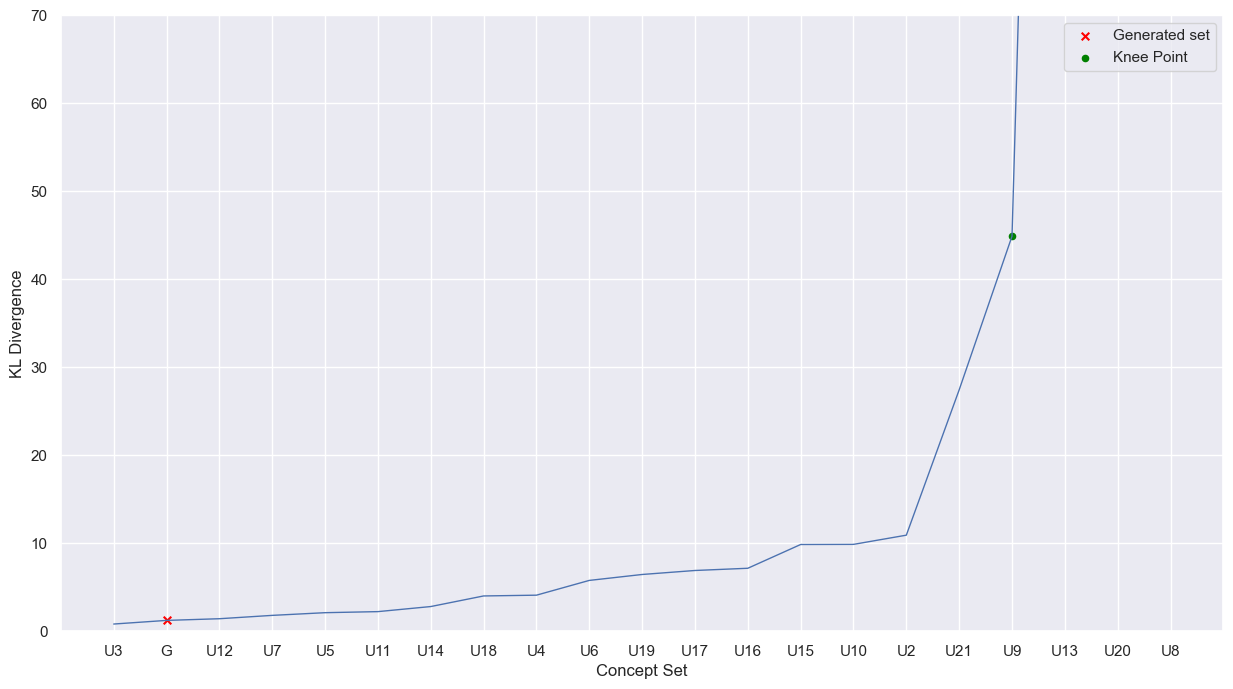

In [69]:
from kneed import KneeLocator

kl_values = sorted(kl_values, reverse = False)

x = np.arange(0, len(kl_values))
y = sorted([i[0] for i in kl_values])

# Finding the knee point
kneedle = KneeLocator(x, y, curve='convex', direction='increasing')
knee_point = kneedle.knee
knee_x, knee_y = knee_point, y[knee_point]

generated_x = [i for i in range(len(kl_values)) if kl_values[i][1] == 1][0]
generated_y = kl_values[generated_x][0]

sns.set()
plt.figure(figsize=(15, 8))
plt.plot(sorted([i[0] for i in kl_values]), linewidth=.99)
plt.scatter(generated_x, generated_y, color='red', marker='x', s=30, label='Generated set')
plt.scatter(knee_x, knee_y, color='green', marker=".", s=80, label='Knee Point')
plt.xlabel("Concept Set")
plt.xticks((range(len(kl_values))), [f"U{i[1]}" if i[1] != 1 else "G" for i in kl_values])
plt.ylabel("KL Divergence")
plt.ylim(0, 70)

plt.legend()

## Compute Matching / Distribution Shift between Users Concepts + Ground Truth Set

In [29]:
# Divergency matrix

divergence_matrix = np.zeros((len(list_of_projections), len(list_of_projections)))
for i in range(len(list_of_projections)):
    for j in range(len(list_of_projections)):
        divergence_matrix[i, j] = compute_multivariate_kullback_leibler(list_of_projections[i], list_of_projections[j])
        

In [30]:
divergence_matrix[0]

array([-8.88178420e-16,  1.18810290e+00,  1.09092345e+01,  8.11456364e-01,
        4.09061254e+00,  2.10048086e+00,  5.76827623e+00,  1.79512963e+00,
        9.46440845e+02,  4.48812539e+01,  9.86393767e+00,  2.22131522e+00,
        1.41470195e+00,  2.53111437e+02,  2.79829754e+00,  9.84933864e+00,
        7.14862929e+00,  6.89595849e+00,  4.00234797e+00,  6.44199942e+00,
        2.95534524e+02,  2.74237558e+01])

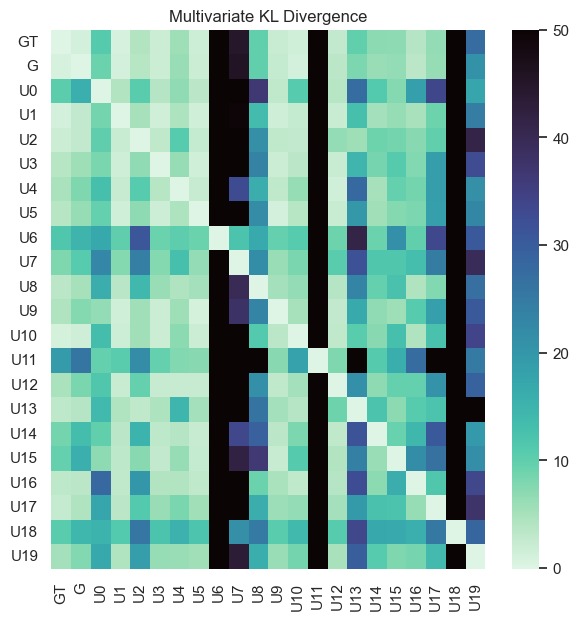

In [31]:
mask = np.triu(np.ones_like(divergence_matrix, dtype=bool)) - np.eye(len(divergence_matrix))

sns.set()

plt.figure(figsize=(7, 7))
sns.heatmap(np.clip(divergence_matrix, 0, 50),
                 annot=False,
                 fmt=".3f",
                 xticklabels=['GT', 'G'] + [f"U{i}" for i in range(len(user_concept_embeddings))],
                 yticklabels=['GT', 'G'] + [f"U{i}" for i in range(len(user_concept_embeddings))],
                 vmin=-0.05,
                 cmap = sns.color_palette("mako_r", as_cmap=True)),
                #  mask=mask)
# sns.heatmap(sns.cm.rocket_r,
#         divergence_matrix, annot=True, mask=mask)
plt.title("Multivariate KL Divergence")
plt.show()


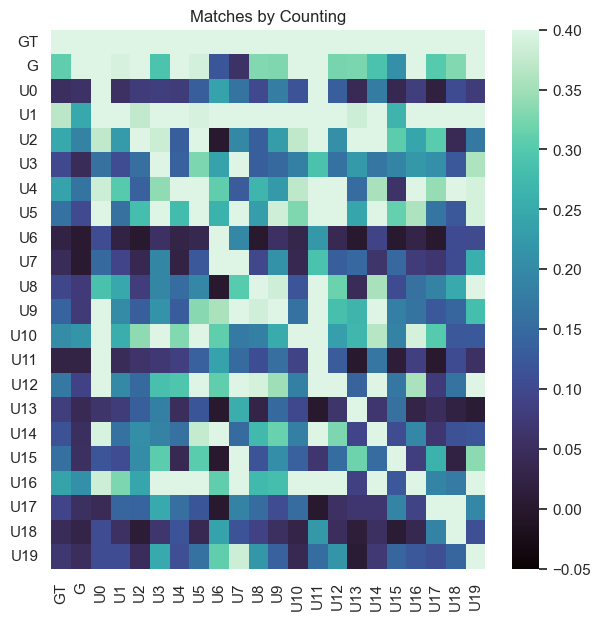

In [32]:
cp = [ground_truth,generated_concepts] + list_user_added

matches_matrix = np.zeros((len(cp), len(cp)))
for i in range(len(cp)):
    for j in range(len(cp)):
        matches_matrix[i, j] = get_matches(extend_concepts(cp[i]), extend_concepts(cp[j]))/len(extend_concepts(cp[j]))

# for i 
#     list_user_added += [user_added]
#     try:
#         user_added = extend_concepts(user_added)
#     except:
#         print(traceback.format_exc())
#     matches += [get_matches(user_added, extend_ground_truth)]


plt.figure(figsize=(7, 7))
sns.heatmap(np.clip(matches_matrix, 0, 0.4),
                 annot=False,
                 fmt=".3f",
                 xticklabels=['GT', 'G'] + [f"U{i}" for i in range(len(user_concept_embeddings))],
                 yticklabels=['GT', 'G'] + [f"U{i}" for i in range(len(user_concept_embeddings))],
                 vmin=-0.05,
                 cmap = sns.color_palette("mako", as_cmap=True)),
                #  mask=mask)
# sns.heatmap(sns.cm.rocket_r,
#         divergence_matrix, annot=True, mask=mask)
plt.title("Matches by Counting")
plt.show() 


## K-Disimilarest ground truth concepts w.r.t. generated ones (extended)

In [33]:
farest_from_opposite = np.array([max(cosine_similarity(sample.reshape(1, -1), opposite.reshape(1, -1)).item() for opposite in generated_concepts_extended_embeddings) for sample in ground_truth_extended_embeddings ])

In [34]:
k = 20
topk = np.argsort(farest_from_opposite)[:k]

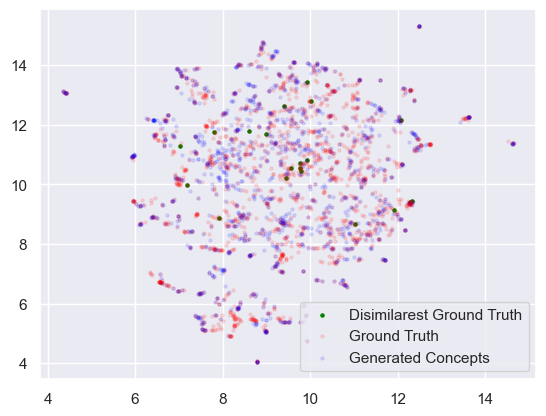

In [35]:

umap_model = UMAP(n_components=2, min_dist=0.0, metric='cosine')

tsne_embeddings = umap_model.fit_transform(torch.cat([ground_truth_extended_embeddings, generated_concepts_extended_embeddings]).detach().numpy())
plt.scatter(tsne_embeddings[topk, 0], tsne_embeddings[topk, 1], color='green', alpha=1, label='Disimilarest Ground Truth', s=5)
plt.scatter(tsne_embeddings[:len(ground_truth_extended_embeddings), 0], tsne_embeddings[:len(ground_truth_extended_embeddings), 1], color='red', alpha=0.1, label='Ground Truth', s=5)
plt.scatter(tsne_embeddings[len(ground_truth_extended_embeddings):, 0], tsne_embeddings[len(ground_truth_extended_embeddings):, 1], color='blue', alpha=0.1, label='Generated Concepts', s=5)

# plt.scatter(tsne_embeddings[len(ground_truth_embeddings):, 0], tsne_embeddings[len(ground_truth_embeddings):, 1], color='blue', alpha=0.7, label='Generated Concepts')
plt.legend()
plt.show()

In [36]:

gt_pov = {'top_farest' : list(np.array(extend_ground_truth)[topk])}

gt_pov['closer_in_generated'] = [extend_generated_concepts[np.argmax([cosine_similarity(gen.reshape(1, -1), gt.reshape(1, -1)) for gen in generated_concepts_extended_embeddings])] for gt in ground_truth_extended_embeddings[topk]]
gt_pov = pd.DataFrame(gt_pov)
gt_pov

top_farest closer_in_generated
0         calorie-free             lactate
1        express_mirth   computing_machine
2           orthogonal           posterior
3              angular              fiddle
4     masquerade_party                host
5           unresolved             package
6        short_circuit              resist
7        meter_reading          in_arrears
8   sign_of_the_zodiac                char
9        short-circuit              resist
10  manner_of_speaking            sounding
11          free-lance           bloodless
12  mathematical_group            tidy_sum
13   Cartesian_product    computing_device
14    wide_of_the_mark               scale
15         knit_stitch              tie-up
16   overseas_telegram                ping
17       all-inclusive             contain
18      unrecognisable    undifferentiated
19      electroneutral              oeuvre

## K-Disimilarest generated concepts w.r.t. ground truth (extended)

In [37]:
farest_from_opposite = np.array([max(cosine_similarity(sample.reshape(1, -1), opposite.reshape(1, -1)).item() for opposite in ground_truth_extended_embeddings) for sample in generated_concepts_extended_embeddings  ])
k = 20
topk = np.argsort(farest_from_opposite)[:k]

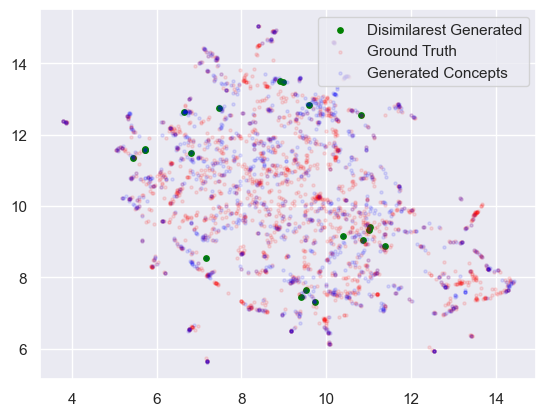

In [38]:

umap_model = UMAP(n_components=2, min_dist=0.0, metric='cosine')

size_gt = len(ground_truth_extended_embeddings)

tsne_embeddings = umap_model.fit_transform(torch.cat([ground_truth_extended_embeddings, generated_concepts_extended_embeddings]).detach().numpy())
plt.scatter(tsne_embeddings[size_gt + topk, 0], tsne_embeddings[size_gt + topk, 1], color='green', alpha=1, label='Disimilarest Generated', s=15)
plt.scatter(tsne_embeddings[:size_gt, 0], tsne_embeddings[:size_gt, 1], color='red', alpha=0.1, label='Ground Truth', s=5)
plt.scatter(tsne_embeddings[size_gt:, 0], tsne_embeddings[size_gt:, 1], color='blue', alpha=0.1, label='Generated Concepts', s=5)

# plt.scatter(tsne_embeddings[len(ground_truth_embeddings):, 0], tsne_embeddings[len(ground_truth_embeddings):, 1], color='blue', alpha=0.7, label='Generated Concepts')
plt.legend()
plt.show()

In [ ]:
g_pov = {'top_farest' : list(np.array(generated_concepts)[topk])}

g_pov['closer_in_gt'] = [extend_ground_truth[np.argmax([cosine_similarity(gen.reshape(1, -1), gt.reshape(1, -1)) for gen in ground_truth_extended_embeddings])] for gt in generated_concepts_extended_embeddings[topk]]
g_pov = pd.DataFrame(g_pov)
g_pov

top_farest   closer_in_gt
0            tabularise       grouping
1            tabularize      colourize
2   newspaper_publisher        booklet
3                 spiel         baffle
4                 nates         whiten
5             posterior      procedure
6           Isle_of_Man    male_person
7          hindquarters           area
8               adjudge         sullen
9                cervix         cerise
10         backbreaking    stretch_out
11              lactate        ferment
12               fiddle         canvas
13               kibosh         emboss
14        tabular_array  table_service
15                await        sleeper
16               hinder       denounce
17  moving-picture_show     photograph
18                 jade        essence
19              rampart         digger

In [ ]:
topk

array([1017,  301,  494,  406,  778,  117, 1035,  338,   74,   60,  435,
         56,  103, 1139,  926,  465, 1098,  379,  850,  346])

## K-Disimilarest ground truth concepts w.r.t. generated ones (initial set) GT Vs. Gen


In [ ]:
farest_from_opposite = np.array([max(cosine_similarity(sample.reshape(1, -1), opposite.reshape(1, -1)).item() for opposite in generated_concepts_embeddings) for sample in ground_truth_embeddings ])
k = 40
topk = np.argsort(farest_from_opposite)[:k]

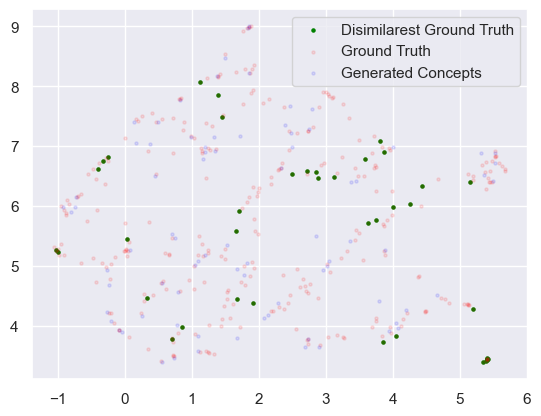

top_farest closer_in_generated
0                     walkie-talkie               beard
1                    1900s  - 1940s             factory
2                       before 1900              papers
3                        2020 - now             working
4                 distilling device          microscope
5                           angular              server
6                        unfriendly                wall
7                    1980s  - 1990s                city
8                    1950s  - 1970s                city
9                      kindergarden             working
10                   unrecognisable           preparing
11                     other decade                city
12           persons of similar age             patient
13                   pouring liquid           preparing
14                    riding a bike             wearing
15               alcohol on a shelf            bookcase
16                          passive              behind
17                          elegant             glasses
18         (partially) out of image              behind
19                            07-17                 tie
20                        dirt/soil              wooden
21                  medium close up              behind
22                           charts                 lab
23  school / classroom / university             kitchen
24                   private sector              office
25                       presenting           preparing
26                      wrist watch             wearing
27                           sparse              blocks
28        more than shoulder length                long
29                          elderly             patient
30                construction site                city
31                            rural             kitchen
32                         friendly             looking
33                         freckles                pink
34                    american shot              camera
35                          diverse               white
36                        elongated                long
37                      freelancing              office
38                         historic                book
39                partially covered              behind

In [ ]:

umap_model = UMAP(n_components=2, min_dist=0.0, metric='cosine')


size_gt = len(ground_truth_embeddings)

tsne_embeddings = umap_model.fit_transform(torch.cat([ground_truth_embeddings, generated_concepts_embeddings]).detach().numpy())
plt.scatter(tsne_embeddings[topk, 0], tsne_embeddings[topk, 1], color='green', alpha=1, label='Disimilarest Ground Truth', s=5)
plt.scatter(tsne_embeddings[:size_gt, 0], tsne_embeddings[:size_gt, 1], color='red', alpha=0.1, label='Ground Truth', s=5)
plt.scatter(tsne_embeddings[size_gt:, 0], tsne_embeddings[size_gt:, 1], color='blue', alpha=0.1, label='Generated Concepts', s=5)

# plt.scatter(tsne_embeddings[len(ground_truth_embeddings):, 0], tsne_embeddings[len(ground_truth_embeddings):, 1], color='blue', alpha=0.7, label='Generated Concepts')
plt.legend()
plt.show()


gt_pov = {'top_farest' : list(np.array(ground_truth)[topk])}

gt_pov['closer_in_generated'] = [generated_concepts[np.argmax([cosine_similarity(gen.reshape(1, -1), gt.reshape(1, -1)) for gen in generated_concepts_embeddings])] for gt in ground_truth_embeddings[topk]]
gt_pov = pd.DataFrame(gt_pov)
gt_pov

## K-Disimilarest generated concepts w.r.t.  ground truth (initial set) (GEN Vs. GT)


In [ ]:
farest_from_opposite = np.array([max(cosine_similarity(sample.reshape(1, -1), opposite.reshape(1, -1)).item() for opposite in ground_truth_embeddings) for sample in generated_concepts_embeddings  ])
k = 20
topk = np.argsort(farest_from_opposite)[:k]

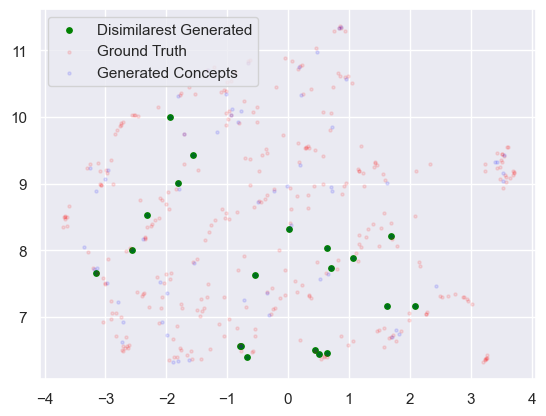

In [ ]:

umap_model = UMAP(n_components=2, min_dist=0.0, metric='cosine')

size_gt = len(ground_truth_embeddings)

# tsne_embeddings = umap_model.fit_transform(torch.cat([ground_truth_embeddings, generated_concepts_embeddings]).detach().numpy())
plt.scatter(tsne_embeddings[size_gt + topk, 0], tsne_embeddings[size_gt + topk, 1], color='green', alpha=1, label='Disimilarest Generated', s=15)
plt.scatter(tsne_embeddings[:size_gt, 0], tsne_embeddings[:size_gt, 1], color='red', alpha=0.1, label='Ground Truth', s=5)
plt.scatter(tsne_embeddings[size_gt:, 0], tsne_embeddings[size_gt:, 1], color='blue', alpha=0.1, label='Generated Concepts', s=5)

plt.legend()
plt.show()

In [ ]:
g_pov = {'top_farest' : list(np.array(generated_concepts)[topk])}

g_pov['closer_in_gt'] = [ground_truth[np.argmax([cosine_similarity(gen.reshape(1, -1), gt.reshape(1, -1)) for gen in ground_truth_embeddings])] for gt in generated_concepts_embeddings[topk]]
g_pov = pd.DataFrame(g_pov)
g_pov

top_farest      closer_in_gt
0          man              male
1    preparing           cooking
2       blocks             boxes
3         hard          hard hat
4       mirror             glass
5        bench           sitting
6      looking              open
7        table              desk
8         stel        stetoscope
9   microscope        laboratory
10       piece             plate
11     officer           uniform
12    surgical        gastronomy
13     playing               fun
14     patient           illness
15      police            people
16       bunch             group
17       nurse          hospital
18    bookcase  books on a shelf
19      safety       safety vest

## K-Disimilarest generated concepts w.r.t.  user K (initial set) (GEN Vs. U_K)


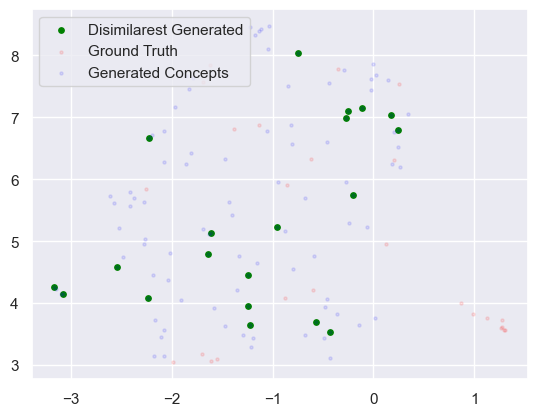

top_farest closer_in_gt
0         mop      working
1        stel    full body
2         dig      working
3        long        happy
4    overalls    full body
5    surgical      working
6     welding      working
7      papers      working
8         pot        shelf
9       brick        shelf
10      field      outdoor
11       chef     portrait
12        hat      uniform
13     blocks        shelf
14   hospital       indoor
15        tie        happy
16       taxi      working
17    holding      working
18        lab        shelf
19   mustache     portrait

In [44]:
farest_from_opposite = np.array([max(cosine_similarity(sample.reshape(1, -1), opposite.reshape(1, -1)).item() for opposite in user_concept_embeddings[0]) for sample in generated_concepts_embeddings  ])
k = 20
topk = np.argsort(farest_from_opposite)[:k]


umap_model = UMAP(n_components=2, min_dist=0.0, metric='cosine')

size_gt = len(user_concept_embeddings[0])

tsne_embeddings = umap_model.fit_transform(torch.cat([user_concept_embeddings[0], generated_concepts_embeddings]).detach().numpy())
plt.scatter(tsne_embeddings[size_gt + topk, 0], tsne_embeddings[size_gt + topk, 1], color='green', alpha=1, label='Disimilarest Generated', s=15)
plt.scatter(tsne_embeddings[:size_gt, 0], tsne_embeddings[:size_gt, 1], color='red', alpha=0.1, label='Ground Truth', s=5)
plt.scatter(tsne_embeddings[size_gt:, 0], tsne_embeddings[size_gt:, 1], color='blue', alpha=0.1, label='Generated Concepts', s=5)

plt.legend()
plt.show()

g_pov = {'top_farest' : list(np.array(generated_concepts)[topk])}
list_user_added
g_pov['closer_in_gt'] = [list_user_added[0][np.argmax([cosine_similarity(gen.reshape(1, -1), gt.reshape(1, -1)) for gen in user_concept_embeddings[0]])] for gt in generated_concepts_embeddings[topk]]
g_pov = pd.DataFrame(g_pov)
g_pov

In [ ]:
user_concept_embeddings[0]

### Image taging as concept modeling

In [126]:
import json
#load the json file
with open('imagenet-1k-labels.txt') as f:
  classes = json.load(f)

In [127]:
from PIL import Image
import requests
from transformers import BlipProcessor, BlipForImageTextRetrieval
import pandas as pd

device = "mps"

# processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
# model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco").to(device)

from glob import glob
import torch

batch_size = 8
images = [image for image in glob("data/*.png")]
texts = list(classes.values())

# global_metrics = None
# for image_batch in range(0, len(images), batch_size):
#     batch_images = [Image.open(image) for image in images[image_batch:image_batch+batch_size]]
#     print(len(batch_images))
#     batch_metrics = None
#     for text_batch in range(0, len(texts), batch_size):
#         batch_texts = [ f"A picture of {jjj}" for jjj in texts[text_batch:text_batch+batch_size] ]
#         inputs = processor(images=batch_images, text=batch_texts, return_tensors="pt", padding=True).to(device)
    
#         itm = model(**inputs, use_itm_head=False)
#         batch_metrics = itm.itm_score.detach().cpu() if batch_metrics is None else torch.cat((batch_metrics, itm.itm_score.detach().cpu()), dim=-1)

#     global_metrics = batch_metrics if global_metrics is None else torch.cat((global_metrics, batch_metrics), dim=0)
# torch.save(global_metrics, 'itm_score.pt')
global_metrics = torch.load('itm_score.pt')

Image: data/Janitor-0052.png


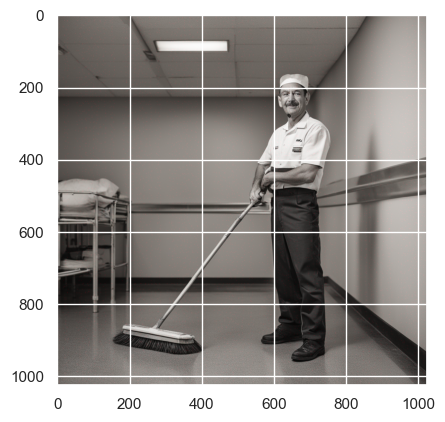

Top 5 classes: ['broom', 'swab, swob, mop', 'prison, prison house', "plunger, plumber's helper", 'admiral']
Image: data/Administrative support worker-0001.png


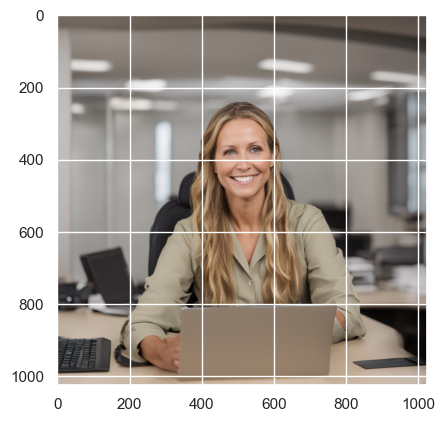

Top 5 classes: ['container ship, containership, container vessel', 'wig', 'purse', 'seashore, coast, seacoast, sea-coast', 'sea lion']
Image: data/Driver-0025.png


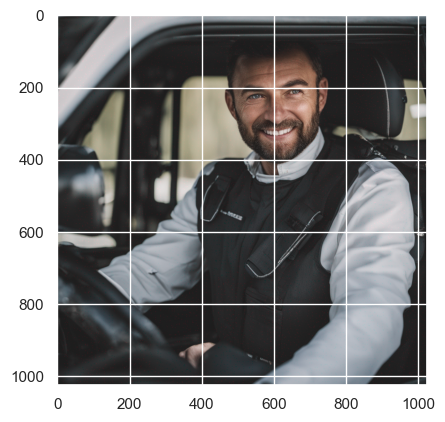

Top 5 classes: ['jeep, landrover', 'bulletproof vest', 'racer, race car, racing car', 'moving van', 'groom, bridegroom']
Image: data/Fabricator-0029.png


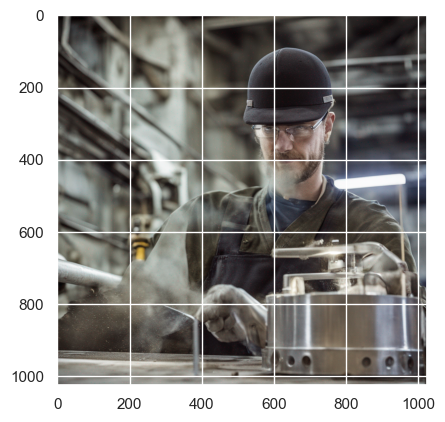

Top 5 classes: ['steel drum', 'gasmask, respirator, gas helmet', 'mousetrap', 'steam locomotive', 'cleaver, meat cleaver, chopper']
Image: data/Postsecondary teacher-0076.png


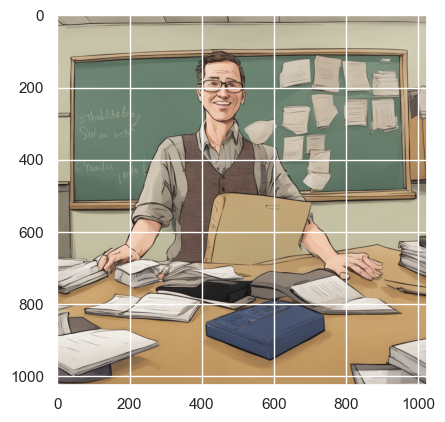

Top 5 classes: ['desk', 'file, file cabinet, filing cabinet', 'comic book', 'admiral', 'wallet, billfold, notecase, pocketbook']


In [128]:
#select top 5 classes per image and plot 5 images randomly with their respective 5 classes
import random
import matplotlib.pyplot as plt

top5 = global_metrics.topk(5, dim=-1).indices
for i in range(5):
    idx = random.randint(0, len(images))
    print(f"Image: {images[idx]}")
    plt.imshow(Image.open(images[idx]))
    plt.show()
    print(f"Top 5 classes: {[texts[j] for j in top5[idx]]}")

In [129]:
#create a list of the 5 top classes for each image
top5_classes = [[texts[j] for j in i] for i in top5]
taglist = list(set([j for i in top5_classes for j in i]))

In [132]:
len(taglist)

162

## Match vs. Ground Truth

In [130]:
print("Initial\n" +
    f"Matches: {get_matches(ground_truth, taglist)}\n \
        Coverage: {get_matches(ground_truth, taglist)/len(ground_truth)}")

print("Extended\n" +
    f"Matches: {get_matches(extend_generated_concepts, extend_concepts(taglist))}\n \
        Coverage: {get_matches(extend_generated_concepts, extend_concepts(taglist))/len(extend_generated_concepts)}")

tag_embeddings = get_embedding(taglist, model, tokenizer)
list_of_projections_tag = torch.tensor(pca.transform(tag_embeddings))

Initial
Matches: 5
         Coverage: 0.015432098765432098
Extended
Matches: 38
         Coverage: 0.028169014084507043


## KL-divergency vs. Ground Truth

In [ ]:

# for embeddings in tqdm([ground_truth_embeddings, generated_concepts_embeddings] + user_concept_embeddings):
compute_multivariate_kullback_leibler(  list_of_projections[0], list_of_projections_tag)

6.356572660364033

In [20]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity


words = ['dog', 'cat', 'apple', 'banana', 'pet', 'fruit']

vectors = model.text_model(**processor(text = words, return_tensors="pt", padding=True)).pooler_output.detach().cpu().numpy()
similarity_matrix = cosine_similarity(vectors)

# Hierarchical clustering
clustering = AgglomerativeClustering(metric='cosine', linkage='average', distance_threshold=0, n_clusters=None)
clustering.fit(similarity_matrix)  

# from scipy.cluster.hierarchy import dendrogram, linkage
# import matplotlib.pyplot as plt

# Z = linkage(similarity_matrix, 'average')
# dendrogram(Z, labels=words)
# plt.show()


AgglomerativeClustering(distance_threshold=0, linkage='average',
                        metric='cosine', n_clusters=None)

In [13]:
x = model.text_model(**processor(text =['hola como estas'], return_tensors="pt", padding=True)).pooler_output.detach().cpu().numpy()
x.shape

(1, 768)